In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit, train_test_split

from tqdm import tqdm
from scipy.signal import periodogram

We begin by loading data and displaying some information about the data

In [125]:
data = pd.read_csv('data/SeoulBikeData.csv')
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Rented Bike Count,8760.0,704.602055,644.997468,0.0,191.00,504.50,1065.25,3556.00
Hour,8760.0,11.500000,6.922582,0.0,5.75,11.50,17.25,23.00
Temperature,8760.0,12.882922,11.944825,-17.8,3.50,13.70,22.50,39.40
Humidity(%),8760.0,58.226256,20.362413,0.0,42.00,57.00,74.00,98.00
Wind speed (m/s),8760.0,1.724909,1.036300,0.0,0.90,1.50,2.30,7.40
Visibility (10m),8760.0,1436.825799,608.298712,27.0,940.00,1698.00,2000.00,2000.00
Dew point temperature,8760.0,4.073813,13.060369,-30.6,-4.70,5.10,14.80,27.20
Solar Radiation (MJ/m2),8760.0,0.569111,0.868746,0.0,0.00,0.01,0.93,3.52
Rainfall(mm),8760.0,0.148687,1.128193,0.0,0.00,0.00,0.00,35.00
Snowfall (cm),8760.0,0.075068,0.436746,0.0,0.00,0.00,0.00,8.80


In [126]:
data.head()

,Date,Rented Bike Count,Hour,Temperature,Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature,Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [127]:
#No nan nor null values
nulls = data.isnull().sum()
nans = data.isna().sum()

print(nulls[nulls>0])
print(nans[nans>0])

Series([], dtype: int64)
Series([], dtype: int64)


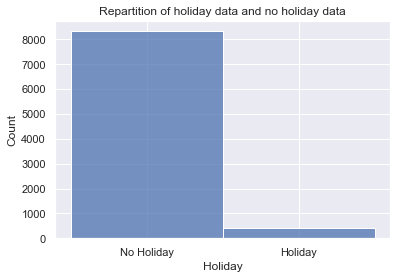

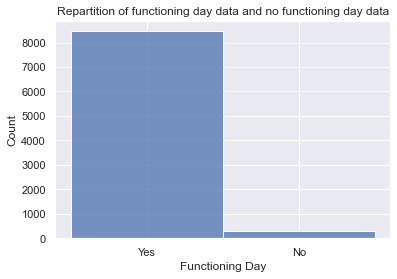

In [128]:
sns.histplot(data=data, x='Holiday')
plt.title('Repartition of holiday data and no holiday data')
plt.show()
sns.histplot(data=data, x='Functioning Day')
plt.title('Repartition of functioning day data and no functioning day data')
plt.show()

We then display the correlation matrix in order to see correlation between input features et the number of rented bikes.
To begin we pass the string data into numerical data

In [129]:
categories = ['Seasons', 'Holiday', 'Functioning Day']
for category in categories:
    data[category] = pd.Categorical(data[category]).codes

In [130]:
#We need to transform Date into features : 
data['day'] = data['Date'].apply(lambda x : datetime.strptime(x,'%d/%m/%Y').weekday())
data['month'] = data['Date'].apply(lambda x : datetime.strptime(x,'%d/%m/%Y').month)
data['year'] = data['Date'].apply(lambda x : datetime.strptime(x,'%d/%m/%Y').year)

<AxesSubplot:>

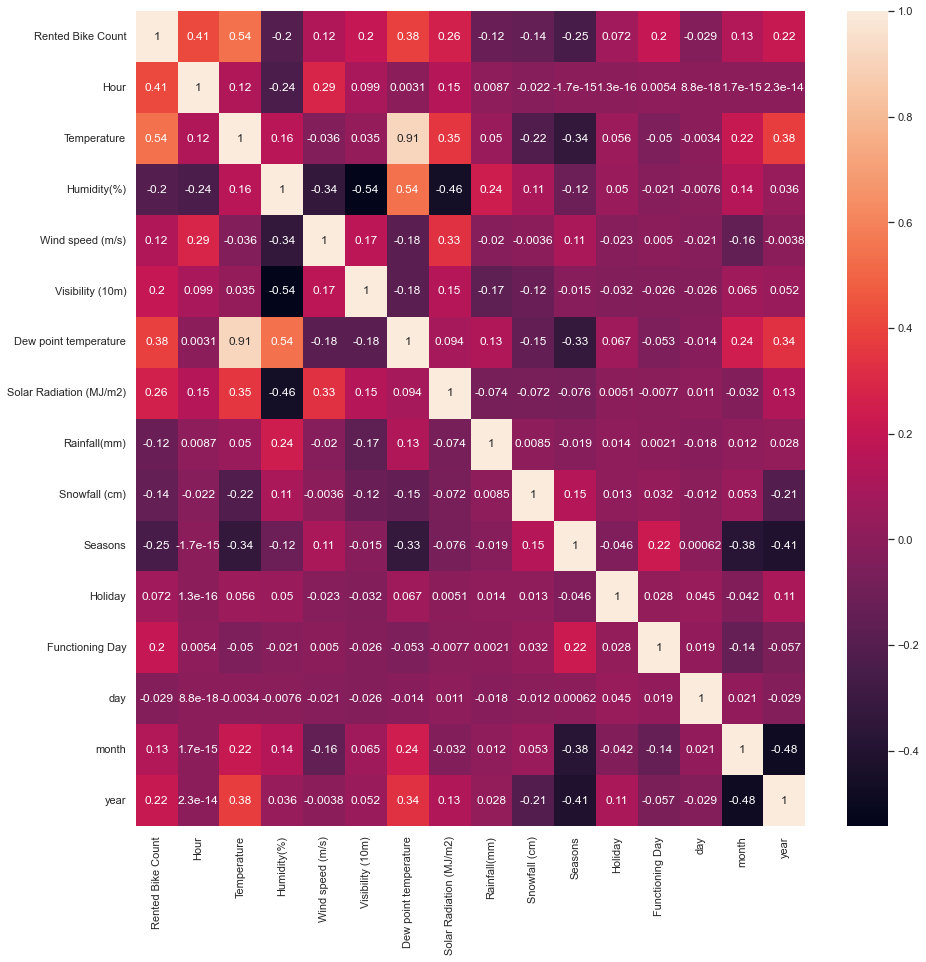

In [131]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data.corr(), annot=True,fmt=".2g", ax=ax)

Text(0.5, 1.0, 'Number of rented bikes as a function of temperature')

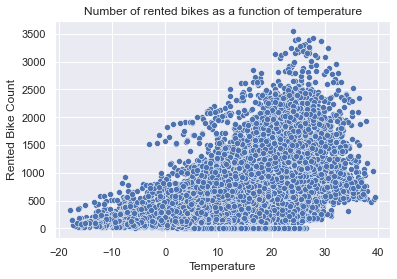

In [132]:
sns.scatterplot(data=data, y='Rented Bike Count', x='Temperature')
plt.title('Number of rented bikes as a function of temperature')

Text(0.5, 1.0, 'Number of mean daily amount of rented bikes as a function of mean temperature of a day')

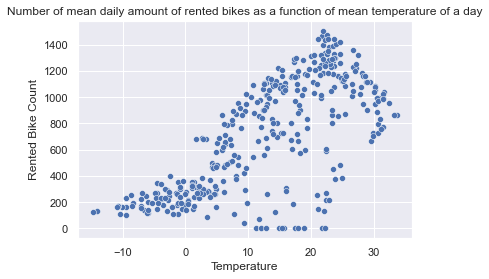

In [133]:
mean_per_day = data.groupby('Date').mean()
sns.scatterplot(data=mean_per_day, x="Temperature", y="Rented Bike Count")
plt.title('Number of mean daily amount of rented bikes as a function of mean temperature of a day')

Text(0.5, 1.0, 'Number of mean daily amount of rented bikes distributed by month')

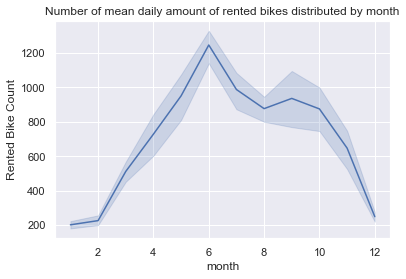

In [134]:
import seaborn as sns
sns.set_theme(style="darkgrid")
mean_per_day = data.groupby('Date').mean()
# Plot the responses for different events and regions
sns.lineplot(data=mean_per_day, x="month", y="Rented Bike Count")
plt.title('Number of mean daily amount of rented bikes distributed by month')

Text(0.5, 1.0, 'Number of mean daily amount of rented bikes distributed by day')

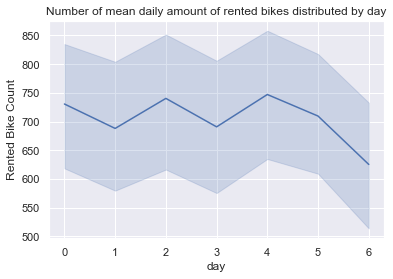

In [135]:
import seaborn as sns
sns.set_theme(style="darkgrid")
mean_per_day = data.groupby('Date').mean()
# Plot the responses for different events and regions
sns.lineplot(data=mean_per_day, x="day", y="Rented Bike Count")
plt.title('Number of mean daily amount of rented bikes distributed by day')

In [136]:
data.drop(['Date'], axis='columns', inplace = True)
#date non utilisée après dans les regressions

In [137]:
#We perform one hot encoding for categorical features
distinct = data.nunique()
print(distinct)
cat_col = list(distinct[distinct<=12].index)
non_cat_feat = list(distinct[distinct>12].index)
data = pd.get_dummies(data, columns = cat_col, drop_first = True)

Rented Bike Count          2166
Hour                         24
Temperature                 546
Humidity(%)                  90
Wind speed (m/s)             65
Visibility (10m)           1789
Dew point temperature       556
Solar Radiation (MJ/m2)     345
Rainfall(mm)                 61
Snowfall (cm)                51
Seasons                       4
Holiday                       2
Functioning Day               2
day                           7
month                        12
year                          2
dtype: int64


In [138]:
non_cat_feat.remove('Rented Bike Count')

We scale data : 

In [139]:
scaler_feat = MinMaxScaler()
data[non_cat_feat] = scaler_feat.fit_transform(data[non_cat_feat])

scaler_out = MinMaxScaler()
data['Rented Bike Count'] = scaler_out.fit_transform(data[['Rented Bike Count']])

We prepare data for future regression : 

In [140]:
features = list(data.columns)
features.remove('Rented Bike Count')

In [141]:
x_data = data[features].to_numpy(dtype=np.float32)
y_data = data['Rented Bike Count'].to_numpy(dtype=np.float32)

In [142]:
poly_2 = PolynomialFeatures(2,include_bias=False)
x_poly_2 = poly_2.fit_transform(x_data)

poly_3 = PolynomialFeatures(3,include_bias=False)
x_poly_3 = poly_3.fit_transform(x_data)

We then perform a grid search in order to search for the best model and the best hyperparameters : 

In [143]:
def test_model(model, X, score):
    cv = ShuffleSplit(n_splits=5, test_size=0.2)
    cv_results = cross_validate(model, X, y_data, cv=cv, scoring=score, return_train_score=True)['test_score']
    mean_cv = cv_results
    return mean_cv

In [144]:
print('Takes approximately 40 seconds')
results = []
models = {'Linear': LinearRegression, 'Ridge': Ridge, 'Lasso': Lasso, 'Elastic Net': ElasticNet, 'Decision tree' : DecisionTreeRegressor, 'Gradient Boosting' : GradientBoostingRegressor}
x_values = {'Degree 1': x_data, 'Degree 2': x_poly_2, 'Degree 3' : x_poly_3}

for x in x_values:
    for model in models:
        new_model = models[model]
        if not (x=='Degree 3' and model=='Linear'):
            if (x=='Degree 3' and model=='Decision tree') or (x=='Degree 2' and model=='Decision tree'):
                pass
            elif (x=='Degree 3' and model=='Gradient Boosting') or (x=='Degree 2' and model=='Gradient Boosting'):
                pass
            else:
                mean= test_model(models[model](), x_values[x], 'neg_mean_squared_error')
                results += [[model, x, -el_mean] for el_mean in mean]

results = pd.DataFrame(results, columns = ['Model', 'Degree', 'MSE'])

Takes approximately 40 seconds


C:\Users\nicol\AppData\Roaming\Python\Python37\site-packages\seaborn\categorical.py:3750: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'MSE on testset for all of the models trained')

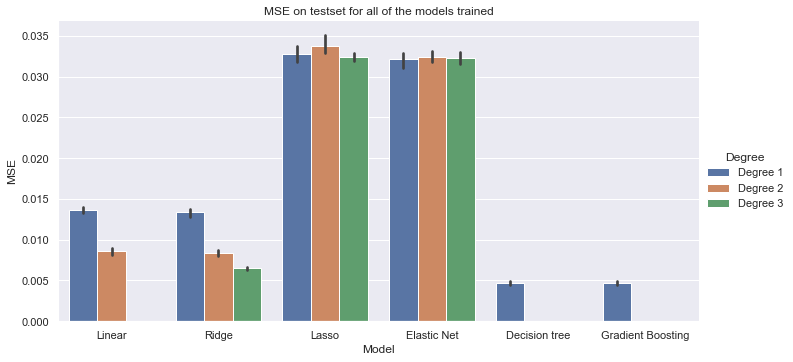

In [145]:
sns.catplot(x='Model', y="MSE", hue='Degree', kind="bar", size=5, aspect=2, data=results)
plt.title('MSE on testset for all of the models trained')

We study more in depth the three best models found : 

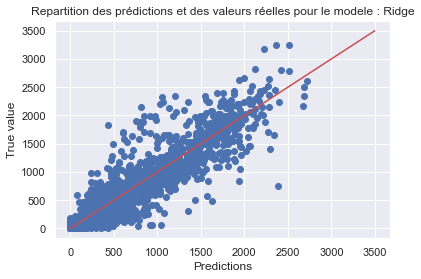

MAE :  186.22029
MSE :  77083.25


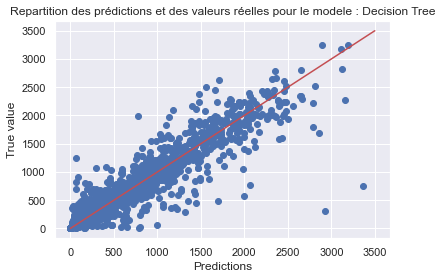

MAE :  129.9874430394687
MSE :  54158.65406505413


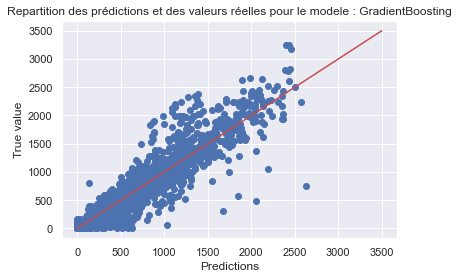

MAE :  158.1855717831683
MSE :  58809.840246185646


In [146]:
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.2)
models = {'Ridge' : Ridge, 'Decision Tree' : DecisionTreeRegressor, 'GradientBoosting' :GradientBoostingRegressor}

def test_model(model, model_name, degree=1):
    if degree!=1:
        poly = PolynomialFeatures(degree, include_bias=False)
        x_tr = poly.fit_transform(x_train) 
        x_te = poly.fit_transform(x_test) 
    else:
        x_tr = x_train
        x_te = x_test
        
    model.fit(x_tr, y_train)
    pred = model.predict(x_te).reshape(-1,1)
    true = y_test.reshape(-1,1)

    real_pred = scaler_out.inverse_transform(pred).clip(min=0)
    real_true = scaler_out.inverse_transform(true)

    plt.scatter(real_pred,real_true)
    plt.xlabel('Predictions')
    plt.ylabel('True value')

    plt.plot([0,3500],[0,3500], color='r')
    plt.title('Repartition des prédictions et des valeurs réelles pour le modele : ' + model_name)
    plt.show()
    print('MAE : ', mean_absolute_error(real_pred, real_true))
    print('MSE : ', mean_squared_error(real_pred, real_true))

for model in models:
    if model=='Ridge':
        test_model(models[model](), degree=3, model_name = model)
    else:
        test_model(models[model](), degree=1, model_name = model)